Este colab fue desarrollado por Arnold Charry Armero.

# Gradient Boosting (Regresión)

Gradient Boosting es un algoritmo de ensamble de Machine Learning que pertenece a la familia de métodos de boosting. La idea principal del boosting es entrenar de manera secuencial varios modelos débiles (típicamente árboles de decisión poco profundos), donde cada nuevo modelo intenta corregir los errores cometidos por los anteriores. Al combinar estos modelos débiles, se obtiene un modelo fuerte y robusto.

En el caso de Gradient Boosting para regresión, la mejora se realiza mediante la técnica de descenso de gradiente funcional. En cada iteración se calculan los pseudo-residuos, que corresponden al negativo del gradiente de la función de pérdida respecto a la predicción actual. Luego, se ajusta un nuevo árbol de decisión a esos residuos para acercar progresivamente las predicciones a los valores reales. Para un solo dato $(x_i, y_i)$, la función de pérdida $\text{MSE}$ modificada es:

$$ L(y_i, F(x_i)) = \tfrac{1}{2} \big(y_i - F(x_i)\big)^2 $$

La pérdida empírica total sobre el dataset $\mathcal{D}=\{(x_i,y_i)\}_{i=1}^n$ es:

$$ \mathcal{L}[F] = \sum_{i=1}^n L(y_i, F(x_i)) = \tfrac{1}{2} \sum_{i=1}^n \big(y_i - F(x_i)\big)^2$$

El modelo inicial es constante y minimiza la pérdida:

$$ F_0(x) = \arg\min_c \sum_{i=1}^n \tfrac{1}{2}(y_i - c)^2 $$

Resolviendo,

$$ F_0(x) = \frac{1}{n} \sum_{i=1}^n y_i = \bar{y} $$

Los pseudo-residuos para cada observación se definen como:

$$ r_{im} = - \left. \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right|_{F = F_{m-1}} $$

En el caso de $\text{MSE}$:

$$ r_{im} = y_i - F_{m-1}(x_i) $$

Se entrena un árbol de regresión $h_m(x)$ para aproximar los pseudo-residuos:

$$ h_m(x_i) \approx r_{im}, \quad i=1,\dots,n $$

El coeficiente $\gamma_m$ se obtiene resolviendo:

$$ \gamma_m = \arg\min_{\gamma} \sum_{i=1}^n \tfrac{1}{2} \Big(y_i - \big(F_{m-1}(x_i) + \gamma h_m(x_i)\big)\Big)^2 $$

Con solución cerrada:

$$ \gamma_m = \frac{\sum_{i=1}^n h_m(x_i) \, r_{im}}{\sum_{i=1}^n h_m(x_i)^2} $$

El modelo se actualiza con tasa de aprendizaje $\nu \in (0,1]$:

$$ F_m(x) = F_{m-1}(x) + \nu \, \gamma_m \, h_m(x) $$

Después de $M$ iteraciones, el modelo final es:

$$ F_M(x) = F_0(x) + \sum_{m=1}^M \nu \, \gamma_m \, h_m(x) $$

Ahora se continúa con la implementación en código,

In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/Advertising Budget and Sales.csv')

In [ ]:
df.head()

,Unnamed: 0,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


Se elimina la primera columna,

In [ ]:
df = df.drop("Unnamed: 0", axis = 1)
df.head()

,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Primero se analiza la base de datos,

In [ ]:
# Se verifica la cantidad de datos
df.shape

(200, 4)

Se puede observar que hay 200 filas. Se observará de qué tipo son estos valores y si hay faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TV Ad Budget ($)         200 non-null    float64
 1   Radio Ad Budget ($)      200 non-null    float64
 2   Newspaper Ad Budget ($)  200 non-null    float64
 3   Sales ($)                200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [ ]:
# Se verifica el tema de los faltantes
df.isnull().sum()[df.isnull().sum() != 0]

,0


Ahora se analizan las características con datos relevantes,

In [ ]:
df.describe()

,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


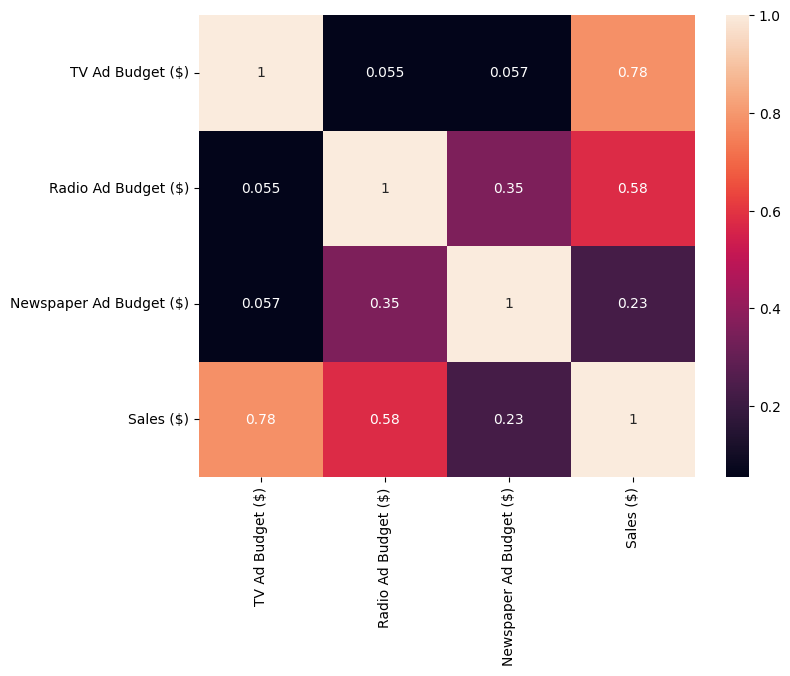

In [ ]:
# Se observa un gráfico de correlación
plt.figure(figsize = (8, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()

  Se hace un gráfico de distribuciones de probabilidad,

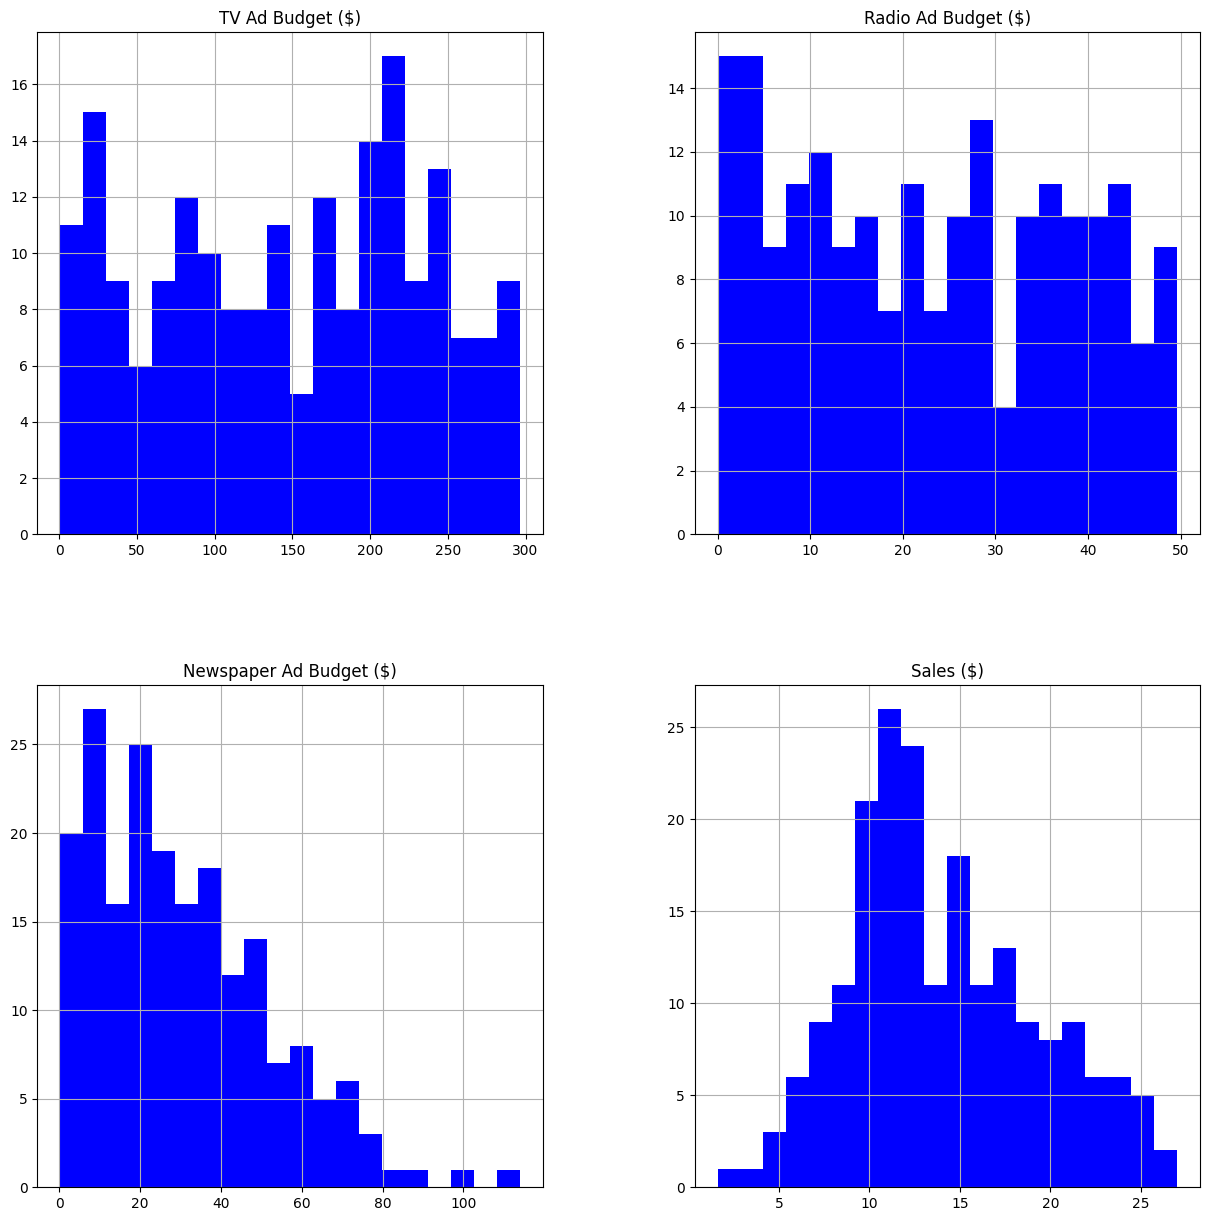

In [ ]:
df.hist(bins = 20, figsize = (15, 15), color = 'b')
plt.show()

## Preprocesamiento de Datos

In [ ]:
# Obtenemos las características
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Visualizar el array X_train
print(X_train)

[[116.    7.7  23.1]
 [177.    9.3   6.4]
 [ 43.1  26.7  35.1]
 [ 62.3  12.6  18.3]
 [224.    2.4  15.6]
 [ 38.2   3.7  13.8]
 [ 70.6  16.   40.8]
 [147.3  23.9  19.1]
 [104.6   5.7  34.4]
 [ 76.3  27.5  16. ]
 [ 78.2  46.8  34.5]
 [168.4   7.1  12.8]
 [  8.7  48.9  75. ]
 [  7.8  38.9  50.6]
 [ 76.4   0.8  14.8]
 [129.4   5.7  31.3]
 [ 73.4  17.   12.9]
 [289.7  42.3  51.2]
 [ 19.6  20.1  17. ]
 [197.6   3.5   5.9]
 [284.3  10.6   6.4]
 [184.9  21.   22. ]
 [112.9  17.4  38.6]
 [ 23.8  35.1  65.9]
 [290.7   4.1   8.5]
 [ 19.4  16.   22.3]
 [293.6  27.7   1.8]
 [ 18.7  12.1  23.4]
 [134.3   4.9   9.3]
 [ 25.6  39.    9.3]
 [100.4   9.6   3.6]
 [ 80.2   0.    9.2]
 [188.4  18.1  25.6]
 [177.   33.4  38.7]
 [125.7  36.9  79.2]
 [209.6  20.6  10.7]
 [142.9  29.3  12.6]
 [184.9  43.9   1.7]
 [222.4   4.3  49.8]
 [241.7  38.   23.2]
 [ 17.2  45.9  69.3]
 [120.5  28.5  14.2]
 [ 89.7   9.9  35.7]
 [191.1  28.7  18.2]
 [ 75.5  10.8   6. ]
 [193.2  18.4  65.7]
 [ 85.7  35.8  49.3]
 [266.9  43.8

## Entrenamiento del Modelo

Ahora vamos con el modelo Gradient Boosting para regresión,

In [ ]:
GB_model = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
GB_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", GB_model.predict(ct.transform([[230.1, 10.8, 45.1]]))[0])

Predicción: 14.99817077939536


In [ ]:
# Obtenemos las predicciones
y_pred = GB_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[17.4193688 ]
 [21.75323977]
 [20.26621166]
 [ 6.51567214]
 [23.61986725]
 [13.04853214]
 [22.85250461]
 [ 9.43520333]
 [11.90058482]
 [15.87305362]
 [ 8.05898068]
 [ 9.21333113]
 [12.35617327]
 [ 4.59831619]
 [10.40360207]
 [12.11962088]
 [ 6.22599474]
 [16.52059978]
 [11.42311669]
 [19.08584766]
 [20.35905024]
 [13.2002411 ]
 [ 9.83436209]
 [22.84129014]
 [10.13026599]
 [ 8.92445042]
 [22.88423501]
 [12.69859929]
 [10.25324871]
 [ 5.51282797]
 [11.3745662 ]
 [11.38200584]
 [21.8829402 ]
 [ 8.56165802]
 [15.62454913]
 [20.73819568]
 [12.22932586]
 [20.23884167]
 [12.29420266]
 [ 7.27484813]]


## Rendimiento del Modelo

In [ ]:
# KPI's del Modelo
MAE = mean_absolute_error(y_test, y_pred)
print('MAE: {:0.2f}%'.format(MAE / np.mean(y_test) * 100))
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
print('RMSE: {:0.2f}%'.format(RMSE / np.mean(y_test) * 100))
r2 = r2_score(y_test, y_pred)
print('R2: {:0.2f}'.format(r2))

MAE: 4.51%
RMSE: 5.32%
R2: 0.98


## Método del Codo para diferentes Árboles

Se hace un gráfico mirando cómo evoluciona el error a medida que se aumenta el número de árboles a entrenar,

In [ ]:
error_rates = []

for n in range(1, 101):
  model = GradientBoostingRegressor(n_estimators = n)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  err = np.sqrt(mean_squared_error(y_test, preds)) / np.mean(y_test) * 100
  error_rates.append(err)

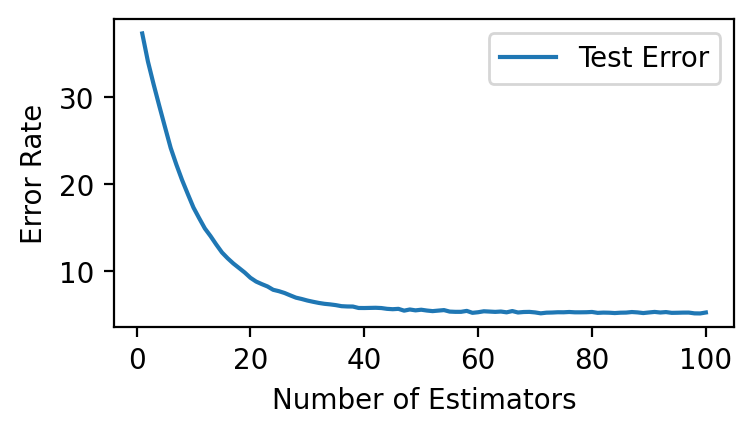

In [ ]:
plt.figure(figsize=(4, 2), dpi=200)
plt.plot(range(1, 101), error_rates, label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("Number of Estimators")
plt.show()

Observando el gráfico, es concluyente que con 100 se tiene un error menor, pero se hace validación cruzada para evitar sobreajuste (overfitting).

## Validación Cruzada y Grid Search

Se mide el error cuadrático medio para la diferente selección de datos de entrenamiento y prueba,

In [ ]:
# Aplicar K-fold Cross Validation
scores = cross_val_score(estimator = GB_model, X = X_train, y = y_train, cv = 10, scoring = 'neg_mean_squared_error')
print(np.sqrt(-scores.mean()))

0.856944999581712


Se conocen los parámetros de Gradient Boosting para evaluar el GridSearch.


In [ ]:
GB_model = GradientBoostingRegressor(random_state = 42)

In [ ]:
# Parámetros
GB_model.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.2, 0.05, 1],
    "max_depth": [3, 4, 5, 6],
    "loss": ["squared_error", "absolute_error", "huber"]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = GB_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'neg_mean_squared_error',
                                  n_jobs = -1,
                                  verbose = 2)

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.05, 1],
                         'loss': ['squared_error', 'absolute_error', 'huber'],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(full_cv_classifier.best_params_)

{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Se obtiene el mejor resultado
print(np.sqrt(-full_cv_classifier.best_score_))

0.7754328847333276


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, loss = "huber", random_state = 42)
model.fit(X_train, y_train)

GradientBoostingRegressor(loss='huber', random_state=42)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[[17.04350427]
 [22.72107191]
 [20.53621242]
 [ 6.49138383]
 [24.46449602]
 [13.08289566]
 [23.20184613]
 [ 9.39617511]
 [11.83400496]
 [15.67280432]
 [ 9.00933077]
 [ 9.08115862]
 [12.33891617]
 [ 4.26313377]
 [10.58319814]
 [12.11875929]
 [ 6.58330634]
 [16.52739594]
 [11.56555356]
 [19.2691904 ]
 [20.06836783]
 [13.53778409]
 [10.05366221]
 [21.37130237]
 [10.03007847]
 [ 8.62452638]
 [22.68364347]
 [12.95016575]
 [10.21800426]
 [ 6.49515343]
 [11.3526999 ]
 [11.50949114]
 [22.61583406]
 [ 8.65173168]
 [15.70420188]
 [19.90673234]
 [11.91719498]
 [20.60143185]
 [12.35142701]
 [ 7.01608472]]


In [ ]:
# Obteniendo la precisión del modelo
print('RMSE: {:0.2f}%'.format(np.sqrt(mean_squared_error(y_test, y_pred)) / np.mean(y_test) * 100))
print('MAE: {:0.2f}%'.format(mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100))
print('R2: {:0.2f}%'.format(r2_score(y_test, y_pred) * 100))

RMSE: 4.60%
MAE: 4.01%
R2: 98.74%


## Referencias

*   Advertising Sales Dataset. (2021, December 25). Kaggle. https://www.kaggle.com/datasets/yasserh/advertising-sales-dataset
*   Hastie, T., Friedman, J., & Tibshirani, R. (2001). The elements of statistical learning. In Springer series in statistics. https://doi.org/10.1007/978-0-387-21606-5
*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.